## 1. Load Splitted Data

In [2]:
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', None)	
import matplotlib.pyplot as plt
import os
os.chdir(r'D:\ME\GeorgeTown\FALL2022\ANLY-590\ANLY590\Data')
import numpy as np
import scipy.sparse
from tqdm import tqdm
import functools

In [3]:
#Load in splitted data
X_train=pd.read_csv(r'data_splitted\X_train_splitted.csv')
y_train=pd.read_csv(r'data_splitted\y_train_splitted.csv')
X_test=pd.read_csv(r'data_splitted\X_test_splitted.csv')
y_test=pd.read_csv(r'data_splitted\y_test_splitted.csv')

In [4]:
X_train.head()

,posting_id,image,image_phash,title
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DOUBLE FOAM TAPE"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter Alhadi
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml


In [5]:
print('Training Size:',X_train.shape)
print('Test Size:',X_test.shape)

Training Size: (34085, 4)
Test Size: (165, 4)


## 2.Preprocess KNN features

In [6]:
#Load Knn features
img_knn_train=pd.read_csv(r'KNN/img_similarity_train.csv')
img_knn_test=pd.read_csv(r'KNN/img_similarity_test.csv')
text_knn_train=pd.read_csv(r'KNN/text_similarity_train.csv')
text_knn_test=pd.read_csv(r'KNN/text_similarity_test.csv')

In [12]:
print(img_knn_train.shape)
print(img_knn_test.shape)
print(text_knn_train.shape)
print(text_knn_test.shape)

(170425, 4)
(825, 4)
(170425, 4)
(825, 4)


In [10]:
img_knn_train.head(10)

,post_idx,top_similar,similar_idx,distance
0,0,1,32996,0.743013
1,0,2,27535,0.964640
2,0,3,30258,0.969116
3,0,4,23990,0.969938
4,0,5,3061,0.971571
5,1,1,445,0.000042
6,1,2,180,0.000062
7,1,3,25034,0.000063
8,1,4,18518,0.000072
9,1,5,23428,0.000169


In [11]:
text_knn_train.head(10)

,post_idx,top_similar,similar_idx,distance
0,0,1,32996,0.000000
1,0,2,9056,1.179860
2,0,3,30994,1.214102
3,0,4,25221,1.217782
4,0,5,2565,1.234942
5,1,1,19097,1.137798
6,1,2,10281,1.137798
7,1,3,21625,1.137798
8,1,4,23158,1.158956
9,1,5,25034,1.169706


In [46]:
#Preprocess training knn
knn_train=pd.merge(img_knn_train,text_knn_train,how='outer',on=['post_idx','similar_idx'],suffixes=['_img','_text'])
for col in ['top_similar_img','top_similar_text','distance_img','distance_text']:knn_train[col].fillna(-9,inplace=True)
for col in ['top_similar_img','top_similar_text']:knn_train[col]=knn_train[col].astype(int)
knn_train['neighbor_label']=knn_train['similar_idx'].apply(lambda x:y_train.iloc[x])
knn_train['label']=knn_train['post_idx'].apply(lambda x:y_train.iloc[x])
knn_train=knn_train.loc[:,['post_idx','label','similar_idx','neighbor_label','top_similar_img','top_similar_text','distance_img','distance_text']]
knn_train['match']=(knn_train['label']==knn_train['neighbor_label'])
knn_train.sort_values(by=['post_idx','distance_text','distance_img'],ascending=True,inplace=True)
print(knn_train.shape)
knn_train.head(10)

(299108, 9)


,post_idx,label,similar_idx,neighbor_label,top_similar_img,top_similar_text,distance_img,distance_text,match
1,0,249114794,27535,656698835,2,-9,0.964640,-9.000000,False
2,0,249114794,30258,1071020646,3,-9,0.969116,-9.000000,False
3,0,249114794,23990,2925334956,4,-9,0.969938,-9.000000,False
4,0,249114794,3061,2008989859,5,-9,0.971571,-9.000000,False
0,0,249114794,32996,249114794,1,1,0.743013,0.000000,True
170425,0,249114794,9056,471581622,-9,2,-9.000000,1.179860,False
170426,0,249114794,30994,471581622,-9,3,-9.000000,1.214102,False
170427,0,249114794,25221,866425052,-9,4,-9.000000,1.217782,False
170428,0,249114794,2565,982607408,-9,5,-9.000000,1.234942,False
5,1,2937985045,445,2819310070,1,-9,0.000042,-9.000000,False


In [29]:
knn_train.to_csv('KNN/knn_train.csv',index=False)

In [47]:
#Preprocess test knn
knn_test=pd.merge(img_knn_test,text_knn_test,how='outer',on=['post_idx','similar_idx'],suffixes=['_img','_text'])
for col in ['top_similar_img','top_similar_text','distance_img','distance_text']:knn_test[col].fillna(-9,inplace=True)
for col in ['top_similar_img','top_similar_text']:knn_test[col]=knn_test[col].astype(int)
knn_test['neighbor_label']=knn_test['similar_idx'].apply(lambda x:y_train.iloc[x])
knn_test['label']=knn_test['post_idx'].apply(lambda x:y_test.iloc[x])
knn_test=knn_test.loc[:,['post_idx','label','similar_idx','neighbor_label','top_similar_img','top_similar_text','distance_img','distance_text']]
knn_test.sort_values(by=['post_idx','distance_text','distance_img'],ascending=True,inplace=True)
knn_test['match']=(knn_test['label']==knn_test['neighbor_label'])
print(knn_test.shape)
knn_test.head(10)

(1577, 9)


,post_idx,label,similar_idx,neighbor_label,top_similar_img,top_similar_text,distance_img,distance_text,match
0,0,994676122,10312,994676122,1,-9,0.000385,-9.000000,True
1,0,994676122,12162,994676122,2,-9,0.000443,-9.000000,True
2,0,994676122,7539,994676122,3,-9,0.000498,-9.000000,True
3,0,994676122,34018,994676122,4,-9,0.000516,-9.000000,True
4,0,994676122,29848,994676122,5,-9,0.000582,-9.000000,True
825,0,994676122,23886,994676122,-9,1,-9.000000,1.158693,True
826,0,994676122,21046,4279411882,-9,2,-9.000000,1.202459,False
827,0,994676122,2194,659879841,-9,3,-9.000000,1.205230,False
828,0,994676122,23151,2210983937,-9,4,-9.000000,1.228327,False
829,0,994676122,21819,2360271488,-9,5,-9.000000,1.229859,False


In [31]:
knn_test.to_csv('KNN/knn_test.csv',index=False)

## 3.Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model=LogisticRegression()
model.fit(knn_train.loc[:,['distance_img','distance_text']],knn_train['match'])

LogisticRegression()

In [49]:
predictions=model.predict(knn_train.loc[:,['distance_img','distance_text']])
print('Train Evaluation')
print(classification_report(knn_train['match'], predictions))

Train Evaluation
              precision    recall  f1-score   support

       False       0.79      0.99      0.88    204181
        True       0.96      0.42      0.58     94927

    accuracy                           0.81    299108
   macro avg       0.87      0.71      0.73    299108
weighted avg       0.84      0.81      0.78    299108



In [50]:
predictions=model.predict(knn_test.loc[:,['distance_img','distance_text']])
print('Test Evaluation')
print(classification_report(knn_test['match'], predictions))

Test Evaluation
              precision    recall  f1-score   support

       False       0.38      1.00      0.55       565
        True       0.99      0.07      0.13      1012

    accuracy                           0.40      1577
   macro avg       0.68      0.53      0.34      1577
weighted avg       0.77      0.40      0.28      1577



In [51]:
model.coef_

array([[0.40229786, 0.32962657]])

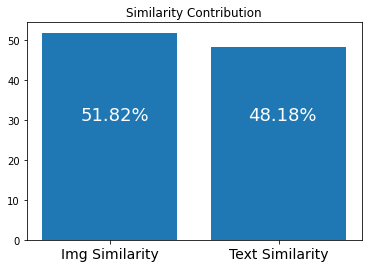

In [73]:
contributions=np.exp(model.coef_[0])/sum(np.exp(model.coef_[0]))*100
plt.bar([0,1],contributions)
plt.xticks([0,1],labels=['Img Similarity','Text Similarity'],fontdict={'size':14})
plt.text(-0.17,30,"{}%".format(round(contributions[0],2)),fontdict={'size':18,'color':'white'})
plt.text(0.82,30,"{}%".format(round(contributions[1],2)),fontdict={'size':18,'color':'white'})
plt.title('Similarity Contribution')
plt.show()

## Top5 Accuracy

Since outer join is used, this is actually not a strict top5 accuracy, but is between top5-top10.

In [81]:
train_eval=pd.read_csv('KNN/knn_train.csv')
train_eval['pred']=model.predict(knn_train.loc[:,['distance_img','distance_text']])
train_eval['correct']=(train_eval['pred']==train_eval['match']).astype(int)
train_eval.head()

,post_idx,label,similar_idx,neighbor_label,top_similar_img,top_similar_text,distance_img,distance_text,match,pred,correct
0,0,249114794,27535,656698835,2,-9,0.964640,-9.0,False,False,1
1,0,249114794,30258,1071020646,3,-9,0.969116,-9.0,False,False,1
2,0,249114794,23990,2925334956,4,-9,0.969938,-9.0,False,False,1
3,0,249114794,3061,2008989859,5,-9,0.971571,-9.0,False,False,1
4,0,249114794,32996,249114794,1,1,0.743013,0.0,True,True,1


In [82]:
test_eval=pd.read_csv('KNN/knn_test.csv')
test_eval['pred']=model.predict(knn_test.loc[:,['distance_img','distance_text']])
test_eval['correct']=(test_eval['pred']==test_eval['match']).astype(int)
test_eval.head()

,post_idx,label,similar_idx,neighbor_label,top_similar_img,top_similar_text,distance_img,distance_text,match,pred,correct
0,0,994676122,10312,994676122,1,-9,0.000385,-9.0,True,False,0
1,0,994676122,12162,994676122,2,-9,0.000443,-9.0,True,False,0
2,0,994676122,7539,994676122,3,-9,0.000498,-9.0,True,False,0
3,0,994676122,34018,994676122,4,-9,0.000516,-9.0,True,False,0
4,0,994676122,29848,994676122,5,-9,0.000582,-9.0,True,False,0


In [95]:
tmp=train_eval.groupby('post_idx').correct.sum().reset_index()
print('Top5 Train Accuracy:',tmp.query('correct>=1').post_idx.count()/tmp.post_idx.count())

Top5 Train Accuracy: 0.9921666422179845


In [96]:
tmp=test_eval.groupby('post_idx').correct.sum().reset_index()
print('Top5 Test Accuracy:',tmp.query('correct>=1').post_idx.count()/tmp.post_idx.count())

Top5 Test Accuracy: 0.9757575757575757
